In [75]:
# SETUP & IMPORTS

import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

print(torch.__version__)


2.1.0+cu121


In [76]:
# Download data from repository
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Teor%C3%ADa/T1/fraud80000_v5.csv -O fraud80000_v5.csv

--2024-02-06 20:14:15--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Teor%C3%ADa/T1/fraud80000_v5.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6346592 (6.1M) [text/plain]
Saving to: ‘fraud80000_v5.csv’

fraud80000_v5.csv   100%[===================>]   6.05M  --.-KB/s    in 0.05s   

2024-02-06 20:14:15 (114 MB/s) - ‘fraud80000_v5.csv’ saved [6346592/6346592]



In [77]:
# DEFINE & CREATE DATASET

class CreditcardDataset(Dataset):

    def __init__(self, csv_file, transform=None):

        self.df = pd.read_csv(csv_file, sep=",")

        y = self.df.iloc[:]['isFraud'].values
        x = self.df.drop('isFraud', axis=1).values

        self.X = torch.tensor(x, dtype=torch.float32)
        self.Y = torch.tensor(y)

        self.transform = transform

        print(self.df.iloc[:]['isFraud'].value_counts())

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

CC_dataset = CreditcardDataset(csv_file='/content/fraud80000_v5.csv')


0    79849
1      151
Name: isFraud, dtype: int64


In [78]:
# PREPARE DATASETS
# Dataset NO balanceado

batch_size = 512
train_split = 0.8 # 80%
val_split = 0.5 # 50% del resto

train_size = int(train_split * len(CC_dataset))
val_size = int(val_split * (len(CC_dataset) - train_size))
test_size = len(CC_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(CC_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True,
                            num_workers=0,
                            #sampler=train_sampler
                            )
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=True,
                            num_workers=0,
                            #sampler=val_sampler
                            )
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=True,
                            num_workers=0,
                            #sampler=test_sampler
                            )

print ("# total samples:", len(CC_dataset))
print ("# total TRAIN samples:", len(train_loader.sampler))
print ("# total VAL samples:", len(val_loader.sampler))
print ("# total TEST samples:", len(test_loader.sampler))

# total samples: 80000
# total TRAIN samples: 64000
# total VAL samples: 8000
# total TEST samples: 8000


In [79]:
# PREPARE DATASETS
# Dataset balanceado

from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm

batch_size = 512
train_split = 0.8 # 80%
val_split = 0.5 # 50% del resto

train_size = int(train_split * len(CC_dataset))
val_size = int(val_split * (len(CC_dataset) - train_size))
test_size = len(CC_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(CC_dataset, [train_size, val_size, test_size])

# WeightedRandomSampler for TRAIN
class_0 = 0
class_1 = 0
train_labels = []
for i in range(len(train_dataset)):
    _, Y = train_dataset[i]

    if Y==0:
        class_0+=1
    else:
        class_1+=1

    train_labels.append(Y)

print ('TRAIN NO_FRAUD: ', class_0)
print ('TRAIN FRAUD:    ', class_1)

class_counts = [class_0, class_1]
num_samples = sum(class_counts)
labels = train_labels #train_dataset.Y #corresponding labels of samples
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
train_sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# WeightedRandomSampler for VAL
class_0 = 0
class_1 = 0
val_labels = []
for i in range(len(val_dataset)):
    _, Y = val_dataset[i]

    if Y==0:
        class_0+=1
    else:
        class_1+=1

    val_labels.append(Y)

print ('VAL NO_FRAUD: ', class_0)
print ('VAL FRAUD:    ', class_1)

class_counts = [class_0, class_1]
num_samples = sum(class_counts)
labels = val_labels
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
val_sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# WeightedRandomSampler for TEST
class_0 = 0
class_1 = 0
test_labels = []
for i in range(len(test_dataset)):
    _, Y = test_dataset[i]

    if Y==0:
        class_0+=1
    else:
        class_1+=1

    test_labels.append(Y)

print ('TEST NO_FRAUD: ', class_0)
print ('TEST FRAUD:    ', class_1)

class_counts = [class_0, class_1]
num_samples = sum(class_counts)
labels = test_labels #train_dataset.Y #corresponding labels of samples
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
test_sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))


train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=train_sampler
                            )
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=val_sampler
                            )
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            #shuffle=True,
                            num_workers=0,
                            sampler=test_sampler
                            )

print ("# total samples:", len(CC_dataset))
print ("# total TRAIN samples:", len(train_loader.sampler))
print ("# total VAL samples:", len(val_loader.sampler))
print ("# total TEST samples:", len(test_loader.sampler))

TRAIN NO_FRAUD:  63880
TRAIN FRAUD:     120
VAL NO_FRAUD:  7986
VAL FRAUD:     14
TEST NO_FRAUD:  7983
TEST FRAUD:     17
# total samples: 80000
# total TRAIN samples: 64000
# total VAL samples: 8000
# total TEST samples: 8000


In [80]:
# ACTIVATE DEVICE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)


cuda:0


'Tesla T4'

In [81]:
# DEFINE NEURAL NETWORK MODEL

class FraudNet(nn.Module):
    def __init__(self):
      ## CAPAS DEL MODELO, LO IMPORTANTE ES DEFINIR TODAS LAS CAPAS SE VAN A USAR EN NUESTRO MODELO ##
        super(FraudNet, self).__init__()
        self.l1 = nn.Linear(5, 32) ## Red que coje 5 variables y va a una capa de 32 neuronas ##
        ## Es una buena práctica expandir la información, no mantener ni reducir ##
        self.l2 = nn.Linear(32, 2) ## Red que coje 32 variables y va a una capa de 2 neruonas, porque queremos dos salidas (fraude o no fraude) ##
        self.relu = nn.ReLU() ## Es una función de activación pero no se entrena ##
        ## Todos los datos negativos los pone a cero y a los positivos le aplica una relación lineal ##

        # Define proportion or neurons to dropout
        ## Coje el vector de entrada, aplica una probabilidad del 0.8 para conservar las conexiones entre capas, ##
        ## basicamente elimina el peso de la conexión ##
        self.dropout = nn.Dropout(0.8) ## Se necesita si tenemos sobreentrenamiento ##

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.l2(x)

        return out

model = FraudNet()
model.to(device)

print (model)

FraudNet(
  (l1): Linear(in_features=5, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.8, inplace=False)
)


In [82]:
# DEFINE LOSS FUNCTION AND OPTIMIZATION METHOD

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [83]:
# DEFINE TRAIN & EVAL FUNCTIONS

def train_model(model, train_loader, criterion, optimizer, epoch):

    model.train()

    total_epoch_loss = 0
    total_epoch_acc = 0

    for i, (X, Y) in enumerate(train_loader):

        X, Y = X.to(device), Y.to(device)

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        num_corrects = (torch.max(outputs, 1)[1].view(Y.size()).data == Y.data).float().sum()
        acc = 100.0 * num_corrects/len(Y)

        if (i+1) % 1000 == 0:
          print (f'Epoch: {epoch+1}, Idx: ({i+1}/{len(train_loader)}), Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss/len(train_loader), total_epoch_acc/len(train_loader)


def eval_model(model, val_loader, criterion):

  model.eval()

  total_epoch_loss = 0
  total_epoch_acc = 0

  with torch.no_grad():

    for i, (X, Y) in enumerate(val_loader):

        X, Y = X.to(device), Y.to(device)

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, Y)

        num_corrects = (torch.max(outputs, 1)[1].view(Y.size()).data == Y.data).float().sum()
        acc = 100.0 * num_corrects/len(Y)

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_loader), total_epoch_acc/len(val_loader)


Epoch: [01/10], Train Loss: 3.674, Train Acc: 62.24%, Val. Loss: 0.566815, Val. Acc: 83.17%
Epoch: [02/10], Train Loss: 0.493, Train Acc: 76.28%, Val. Loss: 0.291668, Val. Acc: 93.98%
Epoch: [03/10], Train Loss: 0.430, Train Acc: 79.01%, Val. Loss: 0.287252, Val. Acc: 93.98%
Epoch: [04/10], Train Loss: 0.386, Train Acc: 80.85%, Val. Loss: 0.277953, Val. Acc: 93.35%
Epoch: [05/10], Train Loss: 0.379, Train Acc: 82.17%, Val. Loss: 0.300663, Val. Acc: 92.91%
Epoch: [06/10], Train Loss: 0.350, Train Acc: 83.25%, Val. Loss: 0.319446, Val. Acc: 92.21%
Epoch: [07/10], Train Loss: 0.340, Train Acc: 83.91%, Val. Loss: 0.319975, Val. Acc: 93.18%
Epoch: [08/10], Train Loss: 0.322, Train Acc: 84.19%, Val. Loss: 0.342053, Val. Acc: 92.54%
Epoch: [09/10], Train Loss: 0.336, Train Acc: 84.23%, Val. Loss: 0.356704, Val. Acc: 89.60%
Epoch: [10/10], Train Loss: 0.320, Train Acc: 84.69%, Val. Loss: 0.390499, Val. Acc: 90.52%


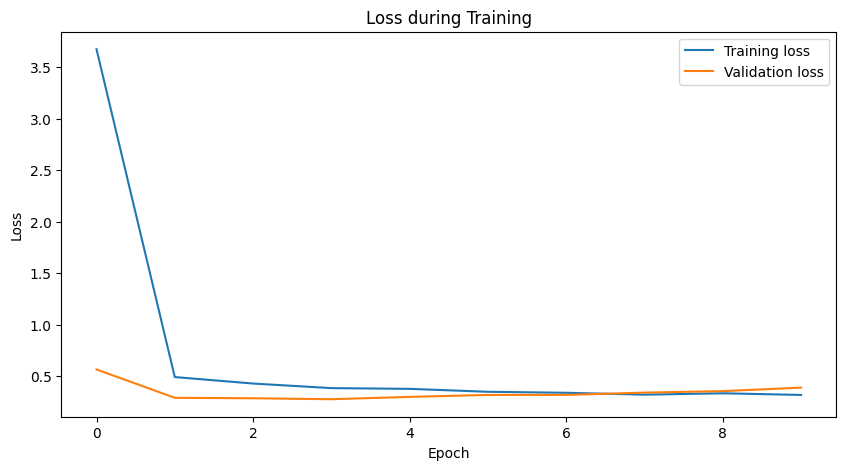

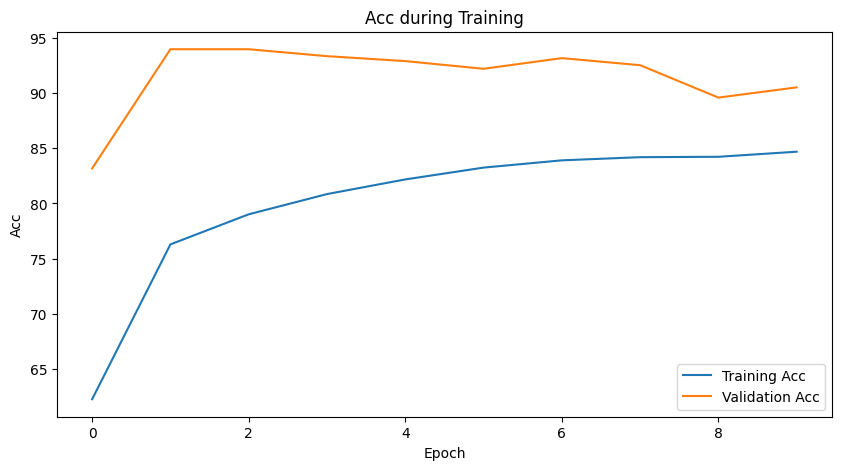

In [84]:
# TRAINING LOOP

epochs = 10

train_loss_epochs = []
val_loss_epochs = []
train_acc_epochs = []
val_acc_epochs = []

for epoch in range(epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc = eval_model(model, val_loader, criterion)

    print(f'Epoch: [{epoch+1:02}/{epochs}], Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')
    train_loss_epochs.append(train_loss)
    val_loss_epochs.append(val_loss)
    train_acc_epochs.append(train_acc)
    val_acc_epochs.append(val_acc)


plt.figure(figsize=(10,5))
plt.title("Loss during Training")
plt.plot(train_loss_epochs,label="Training loss")
plt.plot(val_loss_epochs,label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Acc during Training")
plt.plot(train_acc_epochs,label="Training Acc")
plt.plot(val_acc_epochs,label="Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [85]:
# TEST THE MODEL

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for X, Y in test_loader:

        X, Y = X.to(device), Y.to(device)

        outputs = model(X)

        _, predicted = torch.max(outputs.data, 1)
        n_samples += Y.size(0)
        n_correct += (predicted == Y).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test: {acc} %')

Accuracy of the network on test: 91.0625 %


Accuracy of the network on test: 91.5625 %


<ipython-input-86-5cd6684d54c4>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + listclasses, rotation=90)
<ipython-input-86-5cd6684d54c4>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + listclasses)


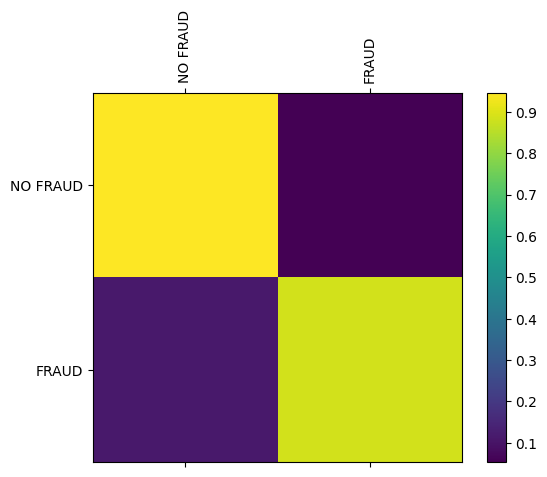

tensor([[0.9468, 0.0532],
        [0.1141, 0.8859]])


In [86]:
# CONFUSION MATRIX

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

listclasses = ['NO FRAUD', 'FRAUD']
numclasses = 2

confusion = torch.zeros(numclasses, numclasses)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for X, Y in test_loader:

        X, Y = X.to(device), Y.to(device)

        outputs = model(X)

        _, predicted = torch.max(outputs.data, 1)
        n_samples += Y.size(0)
        n_correct += (predicted == Y).sum().item()

        for i in range(len(Y)):
          label_i = Y[i]
          predicted_i = predicted[i].item()
          confusion[label_i][predicted_i] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test: {acc} %')

# Normalize by dividing every row by its sum
for i in range(numclasses):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + listclasses, rotation=90)
ax.set_yticklabels([''] + listclasses)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
print (confusion)